In [1]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
nest.ResetKernel()
nest.SetKernelStatus({
    "resolution": 0.1,   # ms
    "print_time": True
})
np.random.seed(42)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Jan 21 07:05:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


# Simple STPD rule simple

In [ ]:
#------------Neuron model parameters (from paper)----------------------------

neuron_params = {
    "C_m": 200.0,        # pF (equivale a tau=20 ms con gL=10 nS)
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

      # Synapse time constants
tau_ex = 5.0    # ms
tau_in = 10.0   # ms





#---------Create neurons -----------------------------------------------------

     # Postsinaptic neuron
post = nest.Create("iaf_cond_alpha",params={**neuron_params, "tau_syn_ex": tau_ex, "tau_syn_in": tau_in})
#nest.GetStatus(post)
     
    # Neuronas presinapticas  
N_exc = 100 # Numero de neuronas excitatorias
N_inh = 25  # Numero de neuoronas inhibitorias
rate_exc = 10.0  # Hz numero de pulsos por segundo
rate_inh = 10.0  # Hz 

exc_inputs = nest.Create("poisson_generator", N_exc, params={"rate": rate_exc})
inh_inputs = nest.Create("poisson_generator", N_inh, params={"rate": rate_inh})
   
   # Crear neuronas parrot
exc_parrots = nest.Create("parrot_neuron", N_exc)
inh_parrots = nest.Create("parrot_neuron", N_inh)

   # Conectar Poisson a parrots
nest.Connect(exc_inputs, exc_parrots)
nest.Connect(inh_inputs, inh_parrots)



In [3]:
# ------ Sinapsis de neuronas exitartorias (estaticas)------
w_exc = 3.0    # nS
delay = 1.0   # ms
nest.Connect(exc_inputs, post, syn_spec={"synapse_model": "static_synapse", "weight": w_exc, "delay": delay})

# ------ Sinapsis de neuronas inhibitorias (STPD rule)------
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": 0.5,
    "delay": delay,
    "eta": 1e-4,
    "alpha": 0.12,
    "tau": 20.0,
    "Wmax": 300.0
}

nest.Connect(inh_parrots, post, syn_spec=inh_syn_params)
conns = nest.GetConnections(inh_parrots, post)

weights = [c["weight"] for c in nest.GetStatus(conns)]
print("Peso inhibitorio promedio:", np.mean(weights))
print("Peso inhibitorio min/max:", np.min(weights), np.max(weights))


Peso inhibitorio promedio: 0.5
Peso inhibitorio min/max: 0.5 0.5


In [ ]:
# PRUEBA 1 Simulación corta 
nest.Simulate(1000.0)
# Pesos inhibitorios después
weights = [c["weight"] for c in nest.GetStatus(conns)]
print("Peso inhibitorio promedio:", np.mean(weights))
print("Peso inhibitorio min/max:", np.min(weights), np.max(weights))


Jan 20 21:16:59 NodeManager::prepare_nodes [Info]: 
    PrePeso inhibitorio promedio: 0.67496131332234
Peso inhibitorio min/max: 0.6501804356262005 0.701361327437714
paring 753 nodes for simulation.

Jan 20 21:16:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 753
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 1000.0 ms, Real-time factor: 2.1236Model time: 69.0 ms, Real-time factor: 2.3204

Jan 20 21:17:01 SimulationManager::run [Info]: 
    Simulation finished.


# STPD Rule with moduled signal 

In [12]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
nest.ResetKernel()
nest.SetKernelStatus({
    "resolution": 0.5,   # ms
    "print_time": True
})
np.random.seed(42)

In [ ]:
#------------Neuron model parameters----------------------------

neuron_params = {
    "C_m": 200.0,        # pF (equivale a tau=20 ms con gL=10 nS)
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

#-------------Synapse time constants--------------------------

tau_ex = 5.0    # ms
tau_in = 10.0   # ms

#---------Create neurons ----------
     # Neurona postsinaptica
post = nest.Create("iaf_cond_alpha",params={**neuron_params, "tau_syn_ex": tau_ex, "tau_syn_in": tau_in})
    # Neuronas presinapticas  
N_exc = 100 # Numero de neuronas excitatorias
N_inh = 25  # Numero de neuoronas inhibitorias
rate_exc = 10.0  # Hz numero de pulsos por segundo
rate_inh = 10.0  # Hz 
   # Crear neuronas parrot 
exc_parrots = nest.Create("parrot_neuron", N_exc)
inh_parrots = nest.Create("parrot_neuron", N_inh)


#----------- Senal modulada en tau = 50 --------
T_sim = 1000.0
dt_signal = 5.0
tau_signal = 50.0
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
noise = np.random.randn(len(times))
signal = np.zeros_like(noise)
alpha = dt_signal / tau_signal

for i in range(1, len(signal)):
    signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])

rate_mean = 10.0
rate_std = 5.0
rates = rate_mean + rate_std * signal
rates[rates < 0.1] = 0.1


#--------------Creear generadores de Poisson modulados -------------
exc_gen = nest.Create(
    "inhomogeneous_poisson_generator",
    params={
        "rate_times": times.tolist(),
        "rate_values": rates.tolist()
    }
)

inh_gen = nest.Create(
    "inhomogeneous_poisson_generator",
    params={
        "rate_times": times.tolist(),
        "rate_values": rates.tolist()
    }
)
#-----------Conectar generadores modulados a parrots(neurons) -------
nest.Connect(exc_gen, exc_parrots)
nest.Connect(inh_gen, inh_parrots)


# ------ Sinapsis de neuronas exitartorias (estaticas)------
w_exc = 3.0    # nS
delay = 1.0   # ms
nest.Connect(exc_parrots, post, syn_spec={"synapse_model": "static_synapse", "weight": w_exc, "delay": delay})

# ------ Sinapsis de neuronas inhibitorias (STPD rule)------
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": 0.5,
    "delay": delay,
    "eta": 1e-4,
    "alpha": 0.12,
    "tau": 20.0,
    "Wmax": 300.0
}
nest.Connect(inh_parrots, post, syn_spec=inh_syn_params)


conns = nest.GetConnections(inh_parrots, post)
weights = [c["weight"] for c in nest.GetStatus(conns)]
print("Peso inhibitorio promedio:", np.mean(weights))
print("Peso inhibitorio min/max:", np.min(weights), np.max(weights))


Peso inhibitorio promedio: 0.5
Peso inhibitorio min/max: 0.5 0.5


In [22]:
#---------Simulacion (Prueba 2)-----------------------------
nest.Simulate(1000.0)

conns = nest.GetConnections(
    source=inh_parrots,
    target=post,
    synapse_model="vogels_sprekeler_synapse"
)

weights = np.array([c["weight"] for c in nest.GetStatus(conns)])

print("Peso inhibitorio promedio:", weights.mean())
print("min/max:", weights.min(), weights.max())


Peso inhibitorio promedio:
Jan 20 21:50:00 NodeManager::prepare_nodes [Info]: 
    P 0.5057588968543881
min/max: 0.5022649357862403 0.5088300164587379
reparing 762 nodes for simulation.

Jan 20 21:50:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 762
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 1000.0 ms, Real-time factor: 1.5056] Model time: 69.0 ms, Real-time factor: 1.7031

Jan 20 21:50:01 SimulationManager::run [Info]: 
    Simulation finished.


In [15]:
#-------------Simulacion 3 ---------------------------------

#---------------Detecor de spike--------------------------
spike_rec = nest.Create("spike_recorder")
nest.Connect(post, spike_rec)
#conns = nest.GetConnections( source=inh_parrots, target=post, synapse_model="vogels_sprekeler_synapse")

#--------------Simulacion de bloques para ver evolucion --------
T_block = 2000.0   # ms
n_blocks = 10  # total = 10 s

rates_post = []
times_post = []

for i in range(1, n_blocks + 1):
    print(f"\n▶ Simulando bloque {i}/{n_blocks} ...")

    nest.Simulate(T_block)

    events = nest.GetStatus(spike_rec, "events")[0]
    spike_times = events["times"]

    rate = len(spike_times) / (T_block / 1000.0)

    rates_post.append(rate)
    times_post.append(i * T_block / 1000.0)

    print(f"   t = {i} s | firing rate = {rate:.2f} Hz")

    # limpiar el recorder
    nest.SetStatus(spike_rec, {"n_events": 0})



▶ Simulando bloque 1/10 ...
   t = 1 s | firing rate = 160.50 Hz

▶ Simulando bloque 2/10 ...
   t = 2 s | firing rate = 161.00 Hz

▶ Simulando bloque 3/10 ...
   t = 3 s | firing rate = 159.00 Hz

▶ Simulando bloque 4/10 ...
   t = 4 s | firing rate = 160.00 Hz

▶ Simulando bloque 5/10 ...
   t = 5 s | firing rate = 161.00 Hz

▶ Simulando bloque 6/10 ...
   t = 6 s | firing rate = 162.00 Hz

▶ Simulando bloque 7/10 ...
   t = 7 s | firing rate = 160.50 Hz

▶ Simulando bloque 8/10 ...
   t = 8 s | firing rate = 160.00 Hz

▶ Simulando bloque 9/10 ...
   t = 9 s | firing rate = 161.00 Hz

▶ Simulando bloque 10/10 ...
   t = 10 s | firing rate = 159.50 Hz


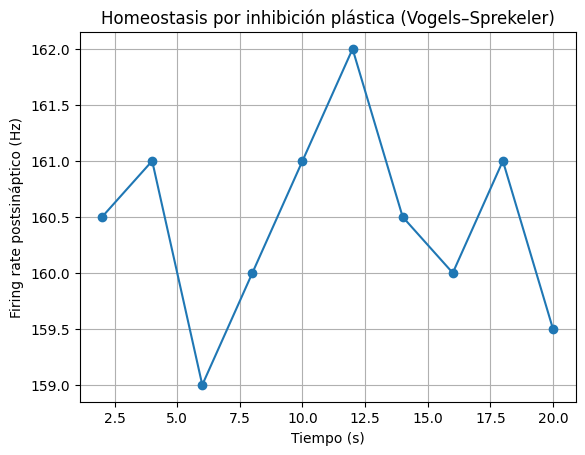

In [17]:
plt.figure()
plt.plot(times_post, rates_post, marker="o")
plt.xlabel("Tiempo (s)")
plt.ylabel("Firing rate postsináptico (Hz)")
plt.title("Homeostasis por inhibición plástica (Vogels–Sprekeler)")
plt.grid(True)
plt.show()
